# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2021spring-ta@googlegroups.com



# Reference - Copyright #
This code references the follwing githib, please follow its BSD License rules:

nikhilbarhate99 : https://github.com/nikhilbarhate99/Actor-Critic-PyTorch/blob/master/LICENSE

BSD 3-Clause License

Copyright (c) 2018,
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.


## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes



Next, set up virtual display，and import all necessaary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [4]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [5]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [7]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [8]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [9]:
observation, reward, done, info = env.step(random_action)

In [10]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [11]:
print(reward)

-0.8588845024543161


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

In [12]:
'''
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
'''

"\nenv.reset()\n\nimg = plt.imshow(env.render(mode='rgb_array'))\n\ndone = False\nwhile not done:\n    action = env.action_space.sample()\n    observation, reward, done, _ = env.step(action)\n\n    img.set_data(env.render(mode='rgb_array'))\n    display.display(plt.gcf())\n    display.clear_output(wait=True)\n"

## Actor-Critic
Now, we can build a simple actor-critic network. The network will return one of action in the action space.

In [13]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        # get in put from the 8 state info
        self.affine = nn.Linear(8, 128)
        
        # actor network
        self.action_layer = nn.Linear(128, 4)
        # value network 
        self.value_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state)
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        action_probs = F.softmax(self.action_layer(state), -1)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        # from last to first to update the Q-function
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards).float()
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            # advantage = TD loss
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]


## Trainin Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [14]:
# Defaults parameters:
#    gamma = 0.99
#    lr = 0.02
#    betas = (0.9, 0.999)
#    random_seed = 543

render = False
gamma = 0.99
lr = 0.02
betas = (0.9, 0.999)

policy = ActorCritic()
optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
print(lr,betas)

total_rewards, final_rewards = [], []
best_model_name = ""
best_reward = 0
running_reward = 0
for i_episode in range(0, 5000):
    state = env.reset()
    total_reward = 0
    for t in range(10000):
        action = policy(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        running_reward += reward
        total_reward += reward

        if render and i_episode > 1000:
            env.render()
        if done:
            total_rewards.append(total_reward)
            final_rewards.append(reward)
            break
                
    # Updating the policy :
    optimizer.zero_grad()
    loss = policy.calculateLoss(gamma)
    loss.backward()
    optimizer.step()        
    policy.clearMemory()
    
    # saving the model if episodes > 999 OR avg reward > 200 
    #if i_episode > 999:
    #    torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
    
    if total_reward > best_reward:
        best_reward = total_reward
        best_model_name = 'LunarLander_actor_critic_{}_{}_{}.pth'.format(lr, betas[0], betas[1])
        torch.save(policy.state_dict(), './preTrained/{}'.format(best_model_name))
        print("Solved model, episode : {}, current best reward = {}".format(i_episode, best_reward))
        #break
    
    if i_episode % 20 == 0:
        running_reward = running_reward/20
        print('Episode {}\tlength: {}\tavg reward: {}'.format(i_episode, t, running_reward))
        running_reward = 0

0.02 (0.9, 0.999)
Episode 0	length: 69	avg reward: -5.056888002199907


<ipython-input-13-9f590d02ea27>:50: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode 20	length: 110	avg reward: -307.42122436970055
Episode 40	length: 104	avg reward: -175.477151755153
Episode 60	length: 88	avg reward: -336.10150854488575
Solved model, episode : 61, current best reward = 20.860058222250174
Episode 80	length: 103	avg reward: -274.5934946420132
Solved model, episode : 91, current best reward = 40.59286688704566
Episode 100	length: 88	avg reward: -248.8138135394707
Episode 120	length: 188	avg reward: -354.0380973385119
Episode 140	length: 125	avg reward: -436.9973233047505
Episode 160	length: 87	avg reward: -233.94848610584214
Episode 180	length: 357	avg reward: -401.3350126282418
Episode 200	length: 145	avg reward: -323.16254596183137
Episode 220	length: 115	avg reward: -118.82696820635044
Episode 240	length: 77	avg reward: -78.10249629566586
Episode 260	length: 89	avg reward: -105.73863192558558
Episode 280	length: 126	avg reward: -137.0991938917173
Episode 300	length: 92	avg reward: -24.41461653479395
Episode 320	length: 86	avg reward: -40.0740

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


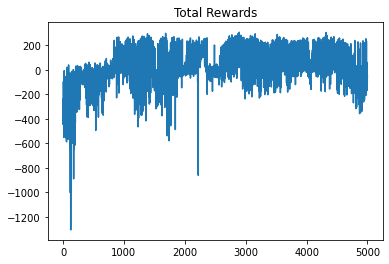

In [15]:
plt.plot(total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


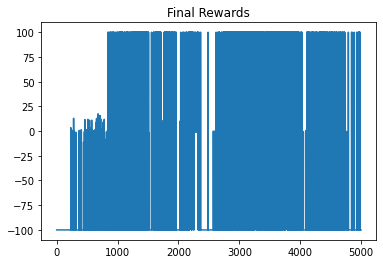

In [16]:
plt.plot(final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

240.04766553587473
118.16433025623448
11.047476332538807
199.5537667877967
140.57423341999993


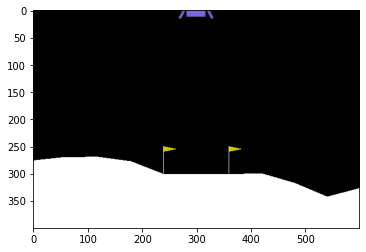

In [18]:
fix(env, seed)
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []

policy = ActorCritic()
policy.load_state_dict(torch.load('./preTrained/{}'.format(best_model_name)))

for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = policy(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


In [19]:
print(np.mean(test_total_reward))

141.8774944664889


Action list

In [20]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 1, 3, 2, 2, 1, 2, 0, 3, 2, 2, 1, 3, 1, 3, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 2, 

/home/siensien/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Analysis of actions taken by agent

In [21]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{1: 1433, 3: 1176, 2: 341, 0: 12}


Saving the result of Model Testing


In [22]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

<ipython-input-22-fd322f3df017>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save(PATH ,np.array(action_list))


### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
'''
from google.colab import files
files.download(PATH)
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : 240.05
Your reward is : 118.16
Your reward is : 11.05
Your reward is : 199.55
Your reward is : 140.57


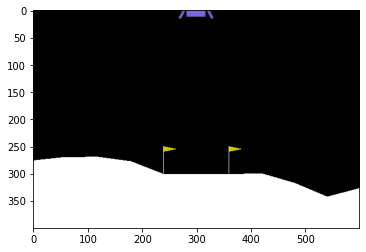

In [23]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [24]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 141.88


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
